# Final Report

In [1]:
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True

# !!! IMPORTANT !!! CHECK whether `t`  is `np.arange(0,20,1/19)`, this affects FFT results 

In [2]:
EGFP = Phasor([0.497,0.503],[2.43,3.07])

In [3]:
EGFP.t[1] == 1/19 #check correctness of time array

True

### Continuous phasor

In [ ]:
#  EGFP.generate_df(func=EGFP.phasor_eq_func_cont)

### Discrete, just trimming

In [ ]:
EGFP.generate_df()

### Discrete, FFT deconvolution

In [ ]:
# EGFP.generate_df(deconv =True)

### Discrete, close-form

In [ ]:
EGFP.generate_df(func = EGFP.phasor_eq_func_DFT)

## PHASOR DF GENERATION
### can skip the commented cell if the csvs are saved

In [ ]:
# N_i = 20  #n_photon number
# N_j = 100 #repeat sim number
# n_photon_arr = np.logspace(4,9,N_i).astype(int)
# df_p_list = []
# for i in range(N_i):
#     EGFP.n_photon = n_photon_arr[i]
#     EGFP.repeat_sim(N_j)
#     df    = EGFP.generate_df(phasor_data = EGFP.phasor_data)[['A1','tau1','tau2','success','nfev']]
#     df_bg = EGFP.generate_df(phasor_data = EGFP.phasor_data_bg)[['A1','tau1','tau2','success','nfev']]
#     df_cont = EGFP.generate_df(func = EGFP.phasor_eq_func_cont)[['A1','tau1','tau2','success','nfev']]
#     df_dis = EGFP.generate_df(func = EGFP.phasor_eq_func_DFT)[['A1','tau1','tau2','success','nfev']]
#     df_deconv = EGFP.generate_df(deconv = True)[['A1','tau1','tau2','success','nfev']]
#     df_p_list.append([df,df_bg,df_cont,df_dis,df_deconv])
# df_p = n_case_df(df_p_list,['no_bg','bg','cont','dis','deconv']) #phasor df for different cases
# # df_p.to_csv('df/df_phasor.csv')

In [4]:
def n_case_df(df_list,col):
    '''Return df for cases in df_list
       Input:
       df_list  list of the structure [[df_1,df_2,...df_n_case],...,] (nested list of 20 (n_photon_arr) by n_case)
       col      col names for the cases'''
    df_list_case = []
    for df in df_list:
        n_val_df =pd.concat(df,keys = col,axis = 1) #concat dfs of n cases along axis 1
        df_list_case.append(n_val_df) #append each photon number case
    return pd.concat(df_list_case,keys = range(20)) 

In [5]:
idx = pd.IndexSlice

In [6]:
N_i = 20  #n_photon number
N_j = 100 #repeat sim number
n_photon_arr = np.logspace(4,9,N_i).astype(int)
# df_lm_list = []
# for i,n_photon in enumerate(n_photon_arr):
#     EGFP.n_photon = n_photon
#     EGFP.repeat_sim(N_j)
#     df_lm_list.append(EGFP.val_df(2,sim_data = EGFP.sim_data, method = 'leastsq')) #store dataframe of 100 sims
# df_lm = pd.concat(df_lm_list,keys = range(20))
# df_lm.columns = pd.MultiIndex.from_product([['no_bg'],list(df_lm.columns)]) #follow col structure of other dfs
# df_lm.to_csv('df/df_lm.csv')#save as lm in the sense of Levenberg Marquardt algorithm

In [7]:
df_mle = pd.read_csv('df/df_mle.csv',header=[0, 1], index_col=[0,1] ) #df_p --df for mle
df_ls  = pd.read_csv('df/df_ls.csv',header=[0, 1], index_col=[0,1] ) #df_ls --df for leastsq
df_p   = pd.read_csv('df/df_phasor.csv',header=[0, 1], index_col=[0,1] ) #df_p --df for phasor
df_lm   = pd.read_csv('df/df_lm.csv',header=[0, 1],index_col=[0,1] ) #df_lm  levenberg marquardts algorithm
df_geo = pd.read_csv('df/df_geo.csv',header=[0, 1], index_col=[0,1] ) #df gemoetric solution

In [8]:
col1,col2 = df_p.columns.levels
true_dict = {'A1' : EGFP.amp[0], 'tau1' : EGFP.tau[0], 'tau2':EGFP.tau[1]} 
def dev_plot(df_names = ['mle','p','geo'], cases = ['no_bg','bg'],pars = ['A1','tau1','tau2'],id_slice = slice(0,len(n_photon_arr))):
        '''Plot mean and std as error bar for diffeent photon count
           df_names    choose list of name of df to be plotted
           cases       e.g. list of cases  no_bg, bg
           pars        list of parameter names
           id_slice    slice for plots array'''
        fig,ax = plt.subplots(1,len(pars),figsize = (4.25*len(pars),4))
        for name in df_names:
                df = df_dict[name]
                for i,par in enumerate(pars):
                        for j,case in enumerate(cases):
                                mean = df.loc(axis=1)[case,par].groupby(level=0).mean()
                                std  = df.loc(axis=1)[case,par].groupby(level=0).std()
                                ax[i].errorbar(n_photon_arr[id_slice],mean[id_slice],yerr=std[id_slice],fmt='x',label = f'{name} {case}')
                                ax[i].set_xscale('log')
                                ax[i].set_xlabel('Total Photon Count')
                                ax[i].set_ylabel(par)
                                ax[i].legend()
                        ax[i].axhline(true_dict[par],c='k',label = 'True')
        return fig,ax
#fig.savefig('fig/phasor_params_cases.pdf')
        

In [9]:
df_dict = {'mle': df_mle, 'ls':df_ls,'lm':df_lm, 'p':df_p,'geo':df_geo}
def hist_plot(sim, n=15,n_photon =None,method = 'powell',df_names = ['mle','lm','p','geo'],cases =['no_bg'],pars = ['A1','tau1','tau2']):
    '''Plot histograms of parameters obtained from repeated simulations
       Inputs:
       sim         Phasor object
       n_photon    total number of photons for simulation
       method      fit method
       df_names    list of keys for df_dict
       cases       list of cases
       pars        list of parameters to be plotted '''
    #set n_photon if it is provided
    n_photon = n_photon_arr[n]
    fig, axes = plt.subplots(nrows=1, ncols=len(pars), figsize=(5*len(pars), 5),constrained_layout = True)
    axes = np.array(axes).flatten()
    fig.suptitle(f'Total number of photons = {n_photon}')
    colors = cm.rainbow(np.linspace(0, 1, len(df_names)))
    for k,case in enumerate(cases):
        for i,par in enumerate(pars):
            # Plot the histogram on the corresponding axis
            if par in true_dict:
                axes[i].axvline(true_dict[par].real,lw = 2,c = 'r',label = 'true')
            for j,name in enumerate(df_names):
                df = df_dict[name]
                val = np.real(df.loc[idx[n,:],idx[case,par]])
                axes[i].hist(np.abs(val),label = f'{name} {case}' ,alpha = 0.5)
                axes[i].axvline(abs(np.mean(val)),lw = 2,ls = '--',c=colors[j],label = f'{name} {case} mean')
            axes[i].legend()
        return fig, axes

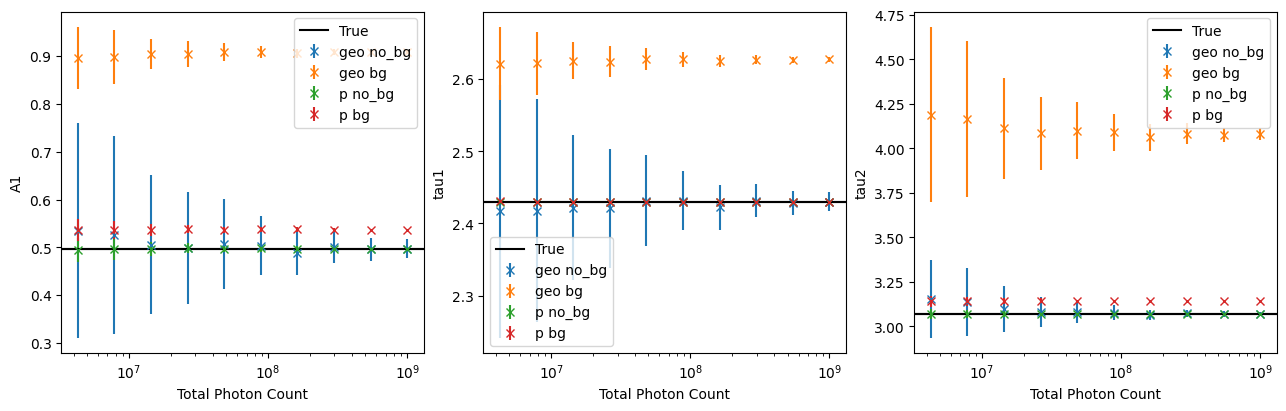

In [10]:
fig,ax = dev_plot(df_names = ['geo','p'], cases = ['no_bg','bg'],id_slice = slice(10,20)) #geometric and numerical comparison

In [136]:
fig.savefig('fig/p_geo_dev.pdf')

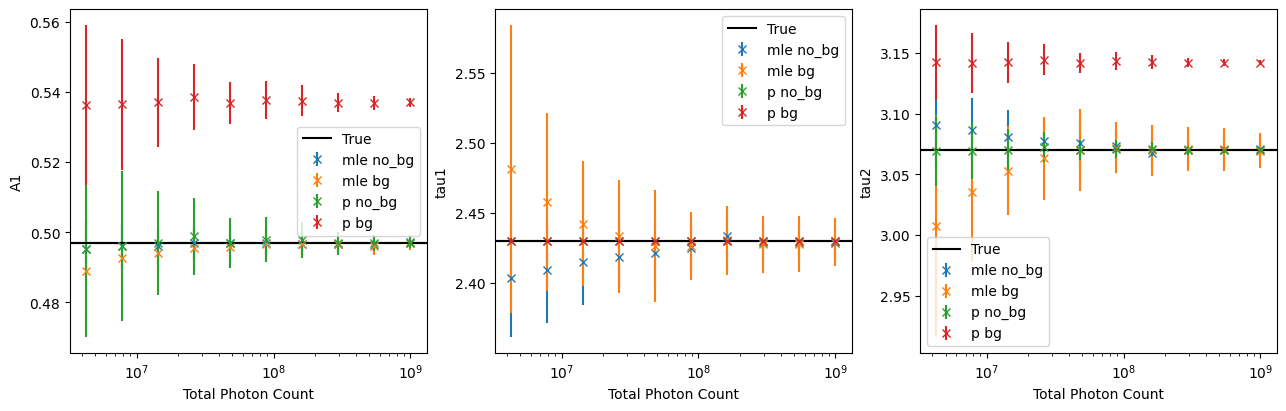

In [11]:
fig,ax = dev_plot(df_names = ['mle','p'], cases = ['no_bg','bg'],id_slice = slice(10,20))

POWELL & LEVENBERG MARQUARDTZ

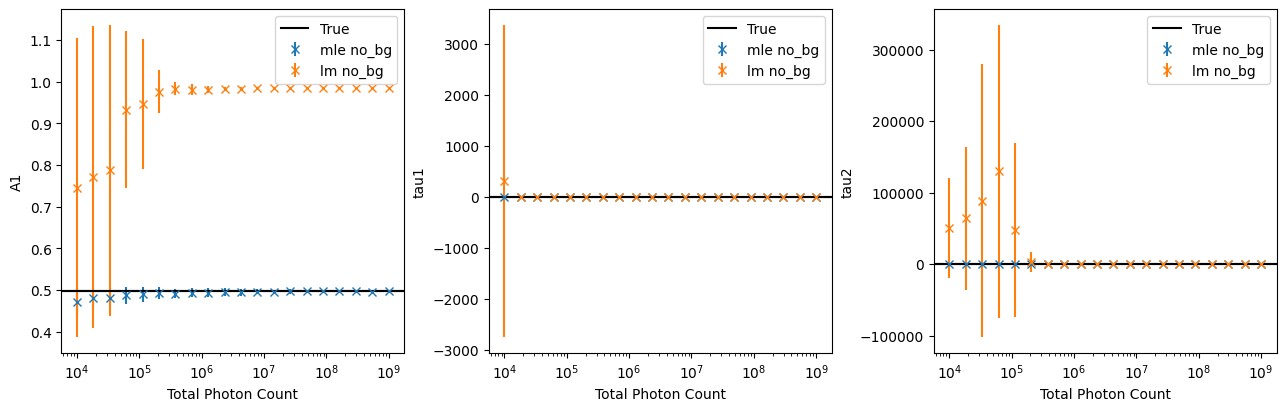

In [13]:
fig,ax = dev_plot(df_names = ['mle','lm'], cases = ['no_bg'],id_slice = slice(0,20)) #geometric and numerical comparison

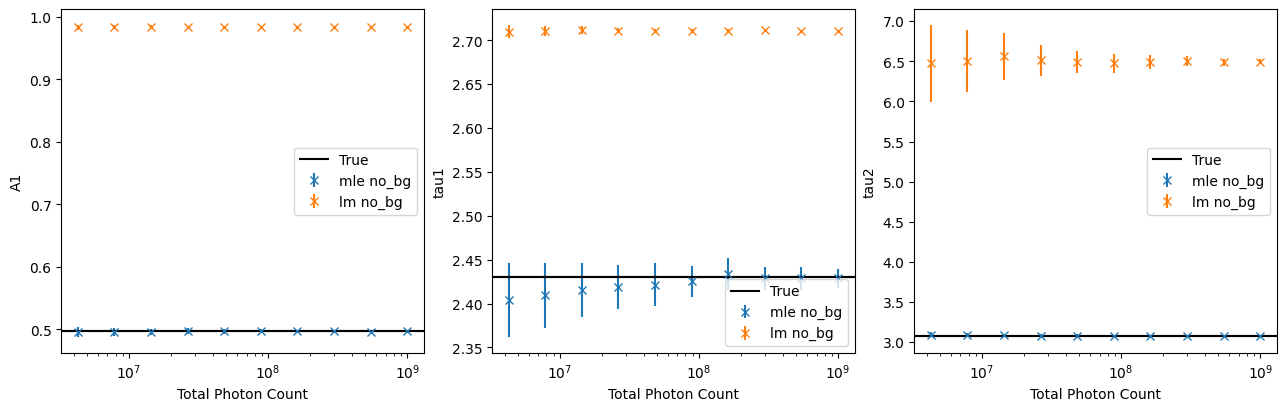

In [14]:
fig,ax = dev_plot(df_names = ['mle','lm'], cases = ['no_bg'],id_slice = slice(10,20)) #geometric and numerical comparison

MLE PHASOR BG NO BG

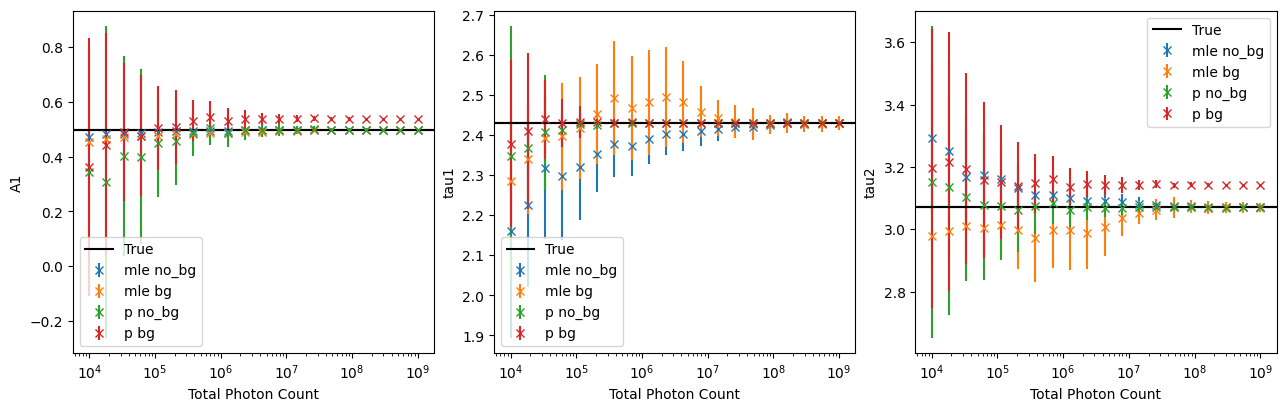

In [15]:
fig,ax = dev_plot(df_names = ['mle','p'], cases = ['no_bg','bg'],id_slice = slice(0,20)) #geometric and numerical comparison

(<Figure size 1500x500 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

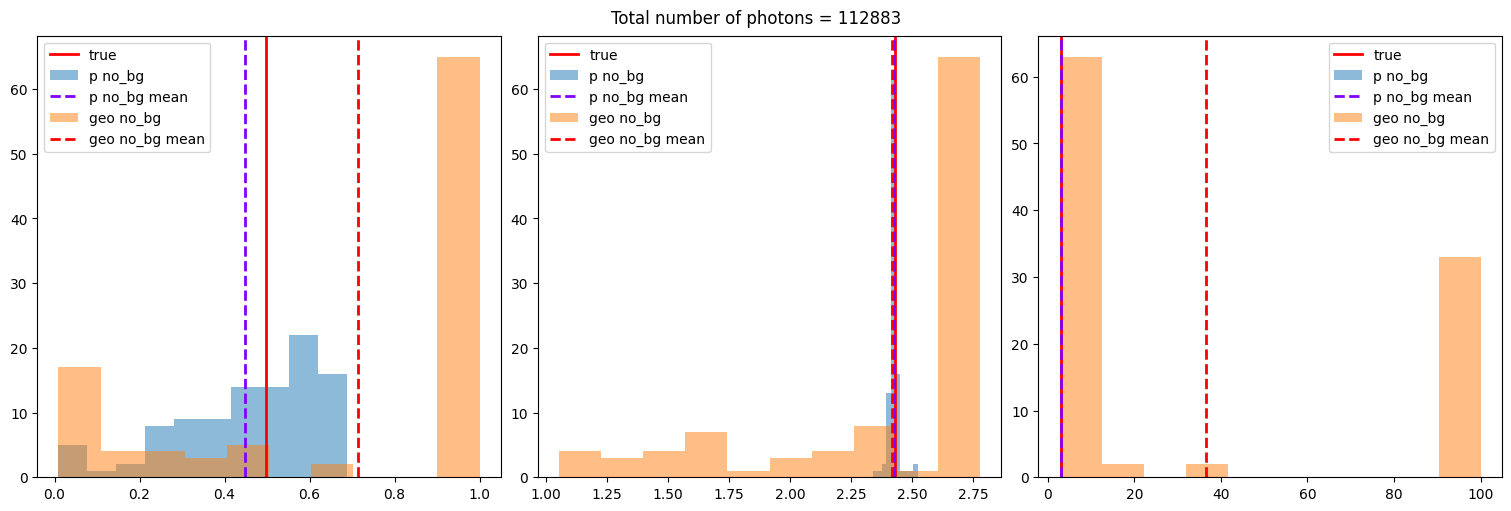

In [137]:
hist_plot(EGFP,n=10,df_names= ['p','geo'],cases = ['no_bg'] )

Reduced $\chi^2$

(<Figure size 500x500 with 1 Axes>, array([<AxesSubplot:>], dtype=object))

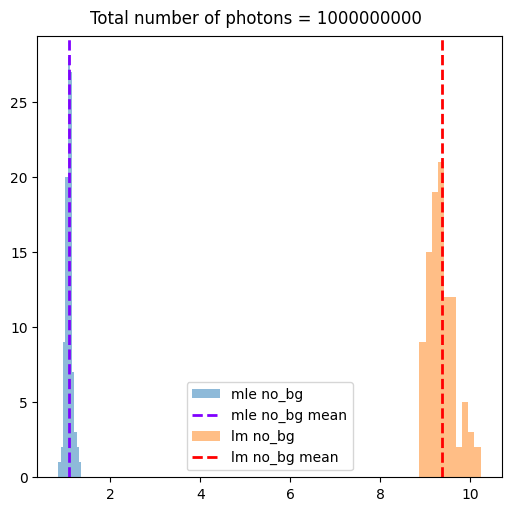

In [145]:
hist_plot(EGFP,n=19,df_names= ['mle','lm'],cases = ['no_bg'],pars = ['red_chi2'] )